In [1]:
from numpy import sin, cos
from IPython.display import HTML
from IPython.core.display import display
from matplotlib import rc

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

import threading
import mloop.interfaces as mli
import mloop.controllers as mlc
import mloop.visualizations as mlv

import mloop.utilities as mlu

Creates a class that solves the equations of motion of a pendulum driven by a time dependent function. Creates an implementation of the interface class, that is used in M-LOOP to connect the experiment (the pendulum simulation) to the learning algorithm. 

In [34]:

def get_cost(th, dth):
    #Cost for stable point = "energy"
    return ((th + np.pi) % (2*np.pi) - np.pi)**2 + dth**2

class PendSolver():
    
    def __init__(self, splits):
        
        self.splits = splits
        
        self.G = 9.8  # acceleration due to gravity, in m/s^2
        self.L = 1.0  # length of pendulum 1 in m
        self.M = 1.0  # mass of pendulum 1 in kg
        self.D = 0.2 # damping
        self.F = 0.0 # force applied to pendulum 1
        
        self.state = np.array([np.pi/2,0.])
        self.dt = 0.05
        
    def derivs(self, state, t):

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[1] = self.F - self.D * state[1] - (self.G/self.L) * sin(state[0])
        
        return dydx
    
    
    def get_next_cost(self, params, show_ani=False, extra_t = 0.0):
        
        # Calculating y (state; angle, derivative) at each timestep
        statet = self.state
        tt = np.arange(0.0, params[0], self.dt)
        self.F = params[1]
        yt = integrate.odeint(self.derivs, statet, tt)
        statet = yt[-1,:]
        y = yt
        for ind in range(self.splits-1):
            tt = np.arange(0.0, params[2*(ind+1)], self.dt)
            self.F = params[2*(ind+1)+1]
            yt = integrate.odeint(self.derivs, statet, tt)
            statet = yt[-1,:]
            y = np.concatenate((y,yt))
        
        if extra_t != 0.0:
            tt = np.arange(0.0, extra_t, self.dt)
            self.F = 0.0
            yt = integrate.odeint(self.derivs, statet, tt)
            y = np.concatenate((y,yt))
        
        x1 = self.L*sin(y[:, 0])
        y1 = -self.L*cos(y[:, 0])
        
        if show_ani:
            fig = plt.figure()
            ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), aspect='equal')
            ax.grid()

            line, = ax.plot([], [], 'o-', lw=2)
            time_template = 'time = %.1fs'
            time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
            cost_template = 'cost = %.1fs'
            cost_text = ax.text(0.05, 0.7, '', transform=ax.transAxes)

            def init():
                line.set_data([], [])
                time_text.set_text('')
                cost_text.set_text('')
                return line, time_text, cost_text

            def animate(i):
                thisx = [0, x1[i]]
                thisy = [0, y1[i]]
                cost = get_cost(y[i,0],y[i,1])
                line.set_data(thisx, thisy)
                time_text.set_text(time_template % (i*self.dt))
                cost_text.set_text(cost_template % cost)
                return line, time_text, cost_text

            ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                                          interval=25, blit=False, init_func=init)
            #plt.show()
            #print(ani._repr_html_())
            display(HTML(ani.to_html5_video()))
        
        th1f = y[-1,0]
        th1df = y[-1,1]
        
        #Cost for stable point = "energy"
        cost = get_cost(y[-1,0], y[-1,1])
        
        #Cost for unstable point
        #cost = ((th1f) % (2*np.pi) - np.pi)**2 + th1df**2
        
        return cost
    
class PendInterface(mli.Interface):
    
    def __init__(self, splits):
        super().__init__()
        self.dpsolver = PendSolver(splits)
        
    def get_next_cost_dict(self,params_dict):
        params = params_dict['params']
        cost = self.dpsolver.get_next_cost(params)
        cost_dict = {'cost':cost}
        return cost_dict

Define the boundary conditions for M-LOOP and create an instance of the interface and the controller.

In [35]:
#The pendulum is driven by a piece wise constant function
#splits defines the number of constant blocks that make up the function
#each block has a variable size in time and height
splits = 2
min_b = []
max_b = []
for ind in range(splits):
    min_b.append(0.05)
    min_b.append(-5)
    max_b.append(1)
    max_b.append(5)
    
#Create an instance of our interface 
# and construct a controller with the boundary conditions and number of parameters set 
interface = PendInterface(splits)
controller = mlc.create_controller(interface, 
                                   max_num_runs = 10,
                                   no_delay=False,
                                   cost_has_noise=False,
                                   num_params=splits*2, 
                                   min_boundary = min_b,
                                   max_boundary = max_b)

Perform the optimization

In [4]:
controller.optimize()

INFO     Optimization started.
INFO     Run:1
INFO     params [ 0.14824661  0.21309306  0.8820159  -0.83123659]
INFO     cost 7.059659143454223 +/- 0.0
INFO     Run:2
INFO     params [ 0.09653356  2.30182155  0.57977708 -0.96961514]
INFO     cost 20.401115748629433 +/- 0.0
INFO     Run:3
INFO     params [ 0.20732979 -3.08275404  0.61217013  3.82272426]
INFO     cost 3.6278210936202706 +/- 0.0
INFO     Run:4
INFO     params [ 0.4458514   1.44324005  0.37131671 -1.66377641]
INFO     cost 17.712025747236606 +/- 0.0
INFO     Run:5
INFO     params [ 0.42131192  4.68209707  0.48230709 -0.80493305]
INFO     cost 14.979349790091405 +/- 0.0
INFO     Run:6
INFO     params [ 0.84243777 -4.5626357   0.35727974  1.80137115]
INFO     cost 8.487471714165409 +/- 0.0
INFO     Run:7
INFO     params [ 0.69166678  2.78586645  0.87464613 -2.8466592 ]
INFO     cost 2.6145261595933738 +/- 0.0
INFO     Run:8
INFO     params [ 0.69523433  4.74980171  0.76683004 -4.11865015]
INFO     cost 6.041203827036597 +/- 

Plot all the defaul visualizations for M-LOOP

INFO     Showing visualizations, close all to end MLOOP.


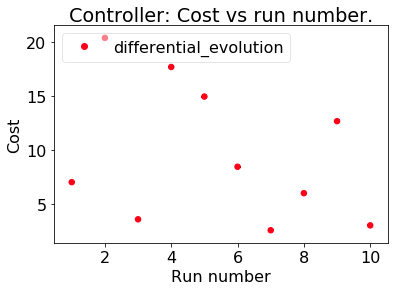

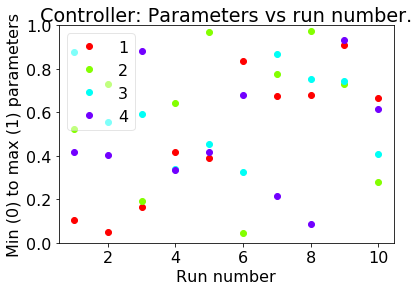

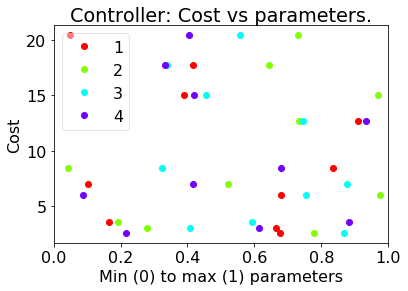

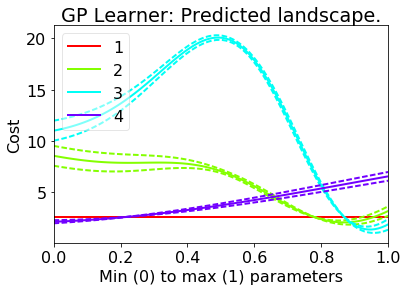

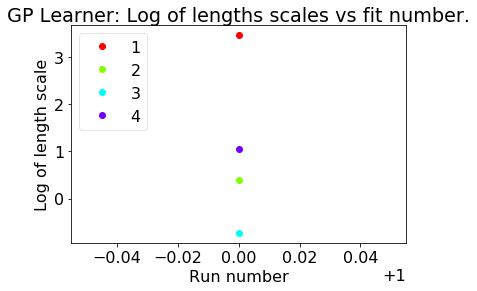

In [5]:
mlv.show_all_default_visualizations(controller)

Plot an animation of the pendulum under the best control found by M-LOOP. Adds an extra 5.0 secodns to the end.

In [19]:
print(controller.best_params)

nan


In [18]:
interface.dpsolver.get_next_cost(controller.best_params, 
                                 show_ani=True, 
                                 extra_t = 5.0)

TypeError: 'float' object is not subscriptable

Plot animation with custom settings

In [36]:
interface.dpsolver.get_next_cost([ 0.69523433,  4.74980171,  0.76683004, -4.11865015], show_ani=True)

6.0412038305664577

In [ ]:
rc('animation', html='html5')